# Luminosities

*Depreciated* in favour of using `isoclassify`. Instead used to explore dominant effects on differing luminosities. We find that the temperature scale appears to dominate. Increased temperature leads to decrased BC which leads to increased luminosities for a given metallicity, extinction and k-band photometry.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

$$\sigma_M^2 = \sigma_m^2 + \left(\frac{5 \sigma_d}{\ln(10) d}\right)^2$$

In [2]:
def absolute_magnitude(magnitude, magnitude_err, distance, distance_err,
                       extinction=0., extinction_err=0.):
    abs_mag = magnitude + 5 - 5 * np.log10(distance) - extinction
    abs_mag_err = np.sqrt(magnitude_err**2 + 
                          25 * distance_err**2 / distance**2 / np.log(10)**2 +
                          extinction_err**2)
    return abs_mag, abs_mag_err

$$\sigma_{M_{BC}}^2 = \sigma_M^2 + \sigma_{BC}^2$$

In [3]:
def bolometric_magnitude(magnitude, magnitude_err, distance, distance_err,
                         bc, bc_err, extinction=0., extinction_err=0.):
    # Absolute bolometric magnitude
    abs_mag, abs_mag_err = absolute_magnitude(magnitude, magnitude_err, distance, distance_err,
                                              extinction, extinction_err)
    bol_mag = abs_mag + bc
    bol_mag_err = np.sqrt(abs_mag_err ** 2 + bc_err ** 2)
    return bol_mag, bol_mag_err

$$\sigma_L^2 = 0.921^2 L^2 \sigma_{M_{BC}}^2$$

In [4]:
def bolometric_luminosity(*args, solar_mag=4.74):
    # Absolute bolometric magnitude
    bol_mag, bol_mag_err = bolometric_magnitude(*args)
    # Luminosity
    luminosity = np.power(10, (solar_mag - bol_mag)/2.5)
    # as Mbol = Mbol_sun - 2.5*log10(L/[L_sun])
    luminosity_err = 0.921*luminosity*bol_mag_err

    return luminosity, luminosity_err

In [5]:
path = '../data/archive/s17-b18-gaia-2mass_bc.csv'

df = pd.read_csv(path)
df.head()

,KIC,numax,enumax,Dnu,eDnu,Length,HBR,Teff_SDSS,eTeff_SDSS,[M/H]_SDSS,...,Aflg,seis_logg_SDSS,seis_logg_err_SDSS,seis_logg_ASPC,seis_logg_err_ASPC,eAV,bc_K_SDSS,bc_K_err_SDSS,bc_G_SDSS,bc_G_err_SDSS
0,1435467,1382.311,19.038,70.558,0.087,938.1,1.662,6433.0,86.0,-0.028,...,0,4.111703,0.007873,4.100044,0.007723,0.04,1.103013,0.042746,0.054203,0.027562
1,2010607,674.919,146.523,42.479,2.185,28.9,1.547,6361.0,71.0,-0.070,...,0,3.797905,0.094409,3.785706,0.094411,0.04,1.112154,0.036232,-0.120773,0.036044
2,2309595,643.208,11.226,39.029,0.721,28.9,1.767,5238.0,65.0,-0.095,...,0,3.734825,0.009083,3.724735,0.009181,0.04,1.731236,0.038113,-0.086824,0.035706
3,2450729,1053.105,114.904,61.910,2.539,28.9,1.470,6029.0,59.0,-0.212,...,0,3.979485,0.047620,3.972583,0.047643,0.04,1.287448,0.031693,-0.068466,0.036927
4,2837475,1629.761,18.396,75.720,0.129,1029.4,1.767,6688.0,57.0,-0.015,...,0,4.191662,0.006726,4.179901,0.006888,0.04,0.978417,0.027737,0.041740,0.030834


In [6]:
df['e_D'] = (df['+e_D'] + df['-e_D']) / 2.0  # <-- either divide by two or take the largest

In [16]:
scale = 'SDSS'
band = 'K'
ext_coeff = 0.161  # http://argonaut.skymaps.info/usage
cols = [f'{band}mag', f'e_{band}mag', 'D', 'e_D',
        f'bc_{band}_{scale}', f'bc_{band}_err_{scale}',
        f'A{band}', f'eA{band}']

df[f'A{band}'] = ext_coeff * df['AV']
df[f'eA{band}'] = ext_coeff * df['eAV']

Add offset to see how BCs effect luminosities.

In [17]:
offset = 0.2
df[f'bc_{band}_{scale}_offset'] = df[f'bc_{band}_{scale}'] + 0.2
cols[4] = f'bc_{band}_{scale}_offset'

In [18]:
scale = f'SDSS+{offset}BC'
df[f'luminosity_{band}_{scale}'], df[f'luminosity_err_{band}_{scale}'] = bolometric_luminosity(*df[cols].to_numpy().T)

In [19]:
df.head()

,KIC,numax,enumax,Dnu,eDnu,Length,HBR,Teff_SDSS,eTeff_SDSS,[M/H]_SDSS,...,bc_G_SDSS,bc_G_err_SDSS,e_D,AK,eAK,luminosity_K_SDSS,luminosity_err_K_SDSS,bc_K_SDSS_offset,luminosity_K_SDSS+0.2BC,luminosity_err_K_SDSS+0.2BC
0,1435467,1382.311,19.038,70.558,0.087,938.1,1.662,6433.0,86.0,-0.028,...,0.054203,0.027562,0.5585,0.003703,0.00644,4.369024,0.190293,1.303013,3.633996,0.158279
1,2010607,674.919,146.523,42.479,2.185,28.9,1.547,6361.0,71.0,-0.070,...,-0.120773,0.036044,10.1290,0.038640,0.00644,9.828233,0.492869,1.312154,8.174768,0.409950
2,2309595,643.208,11.226,39.029,0.721,28.9,1.767,5238.0,65.0,-0.095,...,-0.086824,0.035706,4.1630,0.020930,0.00644,3.887663,0.173967,1.931236,3.233617,0.144699
3,2450729,1053.105,114.904,61.910,2.539,28.9,1.470,6029.0,59.0,-0.212,...,-0.068466,0.036927,2.1610,0.026243,0.00644,3.548918,0.133401,1.487448,2.951862,0.110958
4,2837475,1629.761,18.396,75.720,0.129,1029.4,1.767,6688.0,57.0,-0.015,...,0.041740,0.030834,0.4190,0.006762,0.00644,4.852174,0.178559,1.178417,4.035863,0.148519


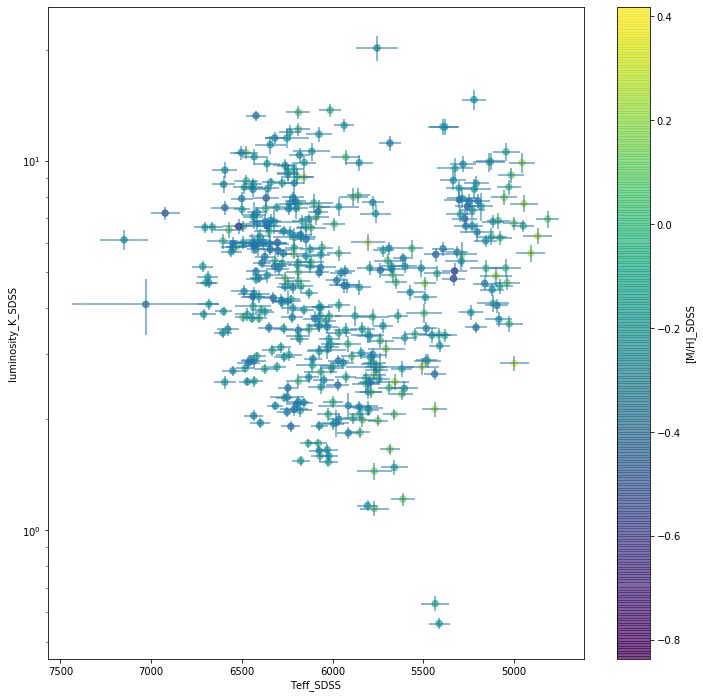

In [11]:
fig, ax = plt.subplots(figsize=(12, 12))

df.plot(ax=ax, kind='scatter', x='Teff_SDSS', y='luminosity_K_SDSS',
        xerr='eTeff_SDSS', yerr='luminosity_err_K_SDSS',
        c='[M/H]_SDSS', cmap='viridis', s=42, alpha=0.7)

ax.invert_xaxis()
ax.set_yscale('log')

In [15]:
m_lim = (0.85, 1.15)
feh_lim = (-0.35, 0.35)

In [16]:
condition = ((df[['Mass_SDSS', 'Mass_ASPC']] > m_lim[0])).all(axis=1) & \
            ((df[['Mass_SDSS', 'Mass_ASPC']] < m_lim[1])).all(axis=1) & \
            ((df[['[M/H]_SDSS', '[M/H]_ASPC']] > feh_lim[0])).all(axis=1) & \
            ((df[['[M/H]_SDSS', '[M/H]_ASPC']] < feh_lim[1])).all(axis=1)

df_cut = df.loc[condition]
print(f'Size = {len(df_cut)}')
df_cut.head()

Size = 73


,KIC,numax,enumax,Dnu,eDnu,Length,HBR,Teff_SDSS,eTeff_SDSS,[M/H]_SDSS,...,eAV,bc_K_SDSS,bc_K_err_SDSS,bc_G_SDSS,bc_G_err_SDSS,e_D,AK,eAK,luminosity_K_SDSS,luminosity_err_K_SDSS
3,2450729,1053.105,114.904,61.910,2.539,28.9,1.470,6029.0,59.0,-0.212,...,0.04,1.287448,0.031693,-0.068466,0.036927,2.1610,0.026243,0.00644,3.548918,0.133401
7,2991448,1111.248,18.148,61.732,0.899,92.6,1.609,5836.0,70.0,-0.085,...,0.04,1.404383,0.037497,0.010756,0.033779,2.3135,0.012075,0.00644,3.504479,0.151716
12,3223000,2573.222,563.234,110.919,1.662,32.4,1.102,6198.0,47.0,-0.185,...,0.04,1.214354,0.025039,0.018509,0.032820,1.0740,0.009660,0.00644,2.192346,0.094194
13,3241581,2807.592,395.565,123.412,2.821,30.0,1.105,5770.0,81.0,0.185,...,0.04,1.453771,0.044111,0.041643,0.030085,0.6430,0.008372,0.00644,1.145651,0.051983
14,3329196,435.093,31.154,29.604,1.193,31.1,7.560,5161.0,65.0,-0.313,...,0.04,1.779080,0.039682,-0.050237,0.031071,1.5470,0.008694,0.00644,4.655553,0.196109


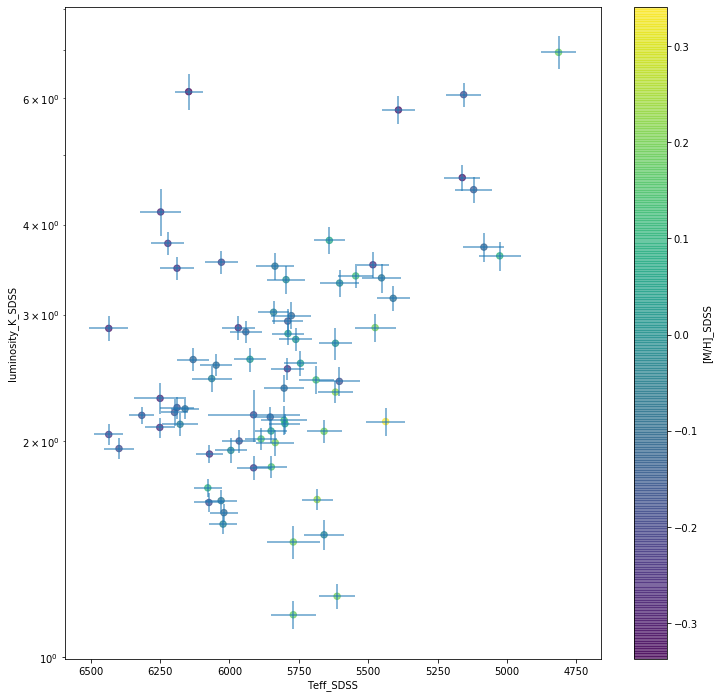

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))

df_cut.plot(ax=ax, kind='scatter', x='Teff_SDSS', y='luminosity_K_SDSS',
            xerr='eTeff_SDSS', yerr='luminosity_err_K_SDSS',
            c='[M/H]_SDSS', cmap='viridis', s=42, alpha=0.7)

ax.invert_xaxis()
ax.set_yscale('log')

In [10]:
df.to_csv('../data/archive/s17-b18-gaia-2mass_lum.csv', index=False)